In [27]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset, DataLoader

In [28]:
df = pd.read_csv("fmnist_small.csv")

In [29]:
# train_test split
x = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [30]:
# — convert arrays to (N, C, H, W) (grayscale → C=1)
x = x.reshape(-1, 1, 28, 28).astype(np.float32) / 255.0
y = y.astype(np.int64)

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Create Dataset + DataLoader with transforms

In [32]:
# — include augmentations for train only
class FMNISTDataset(Dataset):
    def __init__(self, features, labels, transform = None):
        self.features = features
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.features)
        
    def __getitem__(self, index):
        x = self.features[index]
        y = self.labels[index]

        if self.transform:
            x = self.transform(x)

        return x, y

In [33]:
# — include augmentations for train only
class FMNISTDataset(Dataset):
    def __init__(self, features, labels, transform=None):
        self.features = features
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        x = self.features[index]
        y = self.labels[index]

        if self.transform:
            x = self.transform(x)

        return x, y

In [34]:
dataset = FMNISTDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Design CNN architecture

In [35]:
# — conv → relu → pool blocks → FC head.
class cnn(nn.Module):
    
    def __init__(self):
        super(cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size= 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)

    
        self.fc1 = nn.Linear(64 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# Pick loss & optimizer

In [36]:
# — CrossEntropyLoss + Adam/SGD (with momentum)
model = cnn()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# LR schedule & regularization

In [37]:
learning_rate = 0.001
weight_decay = 1e-5
num_epochs = 100

# Training loop with val checks

In [38]:
# — track train/val loss + accuracy each epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [39]:
# training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_accuracy = correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

Epoch 1/100, Loss: 1.1933, Accuracy: 0.5529
Epoch 2/100, Loss: 0.7139, Accuracy: 0.7306
Epoch 3/100, Loss: 0.6110, Accuracy: 0.7671
Epoch 4/100, Loss: 0.5558, Accuracy: 0.7846
Epoch 5/100, Loss: 0.5072, Accuracy: 0.8092
Epoch 6/100, Loss: 0.4578, Accuracy: 0.8213
Epoch 7/100, Loss: 0.4270, Accuracy: 0.8335
Epoch 8/100, Loss: 0.3915, Accuracy: 0.8521
Epoch 9/100, Loss: 0.3753, Accuracy: 0.8548
Epoch 10/100, Loss: 0.3433, Accuracy: 0.8696
Epoch 11/100, Loss: 0.3272, Accuracy: 0.8769
Epoch 12/100, Loss: 0.3096, Accuracy: 0.8817
Epoch 13/100, Loss: 0.2861, Accuracy: 0.8952
Epoch 14/100, Loss: 0.2783, Accuracy: 0.8944
Epoch 15/100, Loss: 0.2496, Accuracy: 0.9077
Epoch 16/100, Loss: 0.2508, Accuracy: 0.9017
Epoch 17/100, Loss: 0.2237, Accuracy: 0.9146
Epoch 18/100, Loss: 0.2109, Accuracy: 0.9194
Epoch 19/100, Loss: 0.2049, Accuracy: 0.9227
Epoch 20/100, Loss: 0.1895, Accuracy: 0.9302
Epoch 21/100, Loss: 0.1810, Accuracy: 0.9302
Epoch 22/100, Loss: 0.1657, Accuracy: 0.9387
Epoch 23/100, Loss:

# Evaluation on test set

In [40]:
# evaluation loop on test set
model.eval()
with torch.no_grad():
    test_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in DataLoader(FMNISTDataset(X_test, y_test), batch_size = 32):
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = test_loss / total
    epoch_accuracy = correct / total
    print(f'Test Loss: {epoch_loss:.4f}, Test Accuracy: {epoch_accuracy:.4f}')



Test Loss: 1.3077, Test Accuracy: 0.8683


# Visualize model behavior

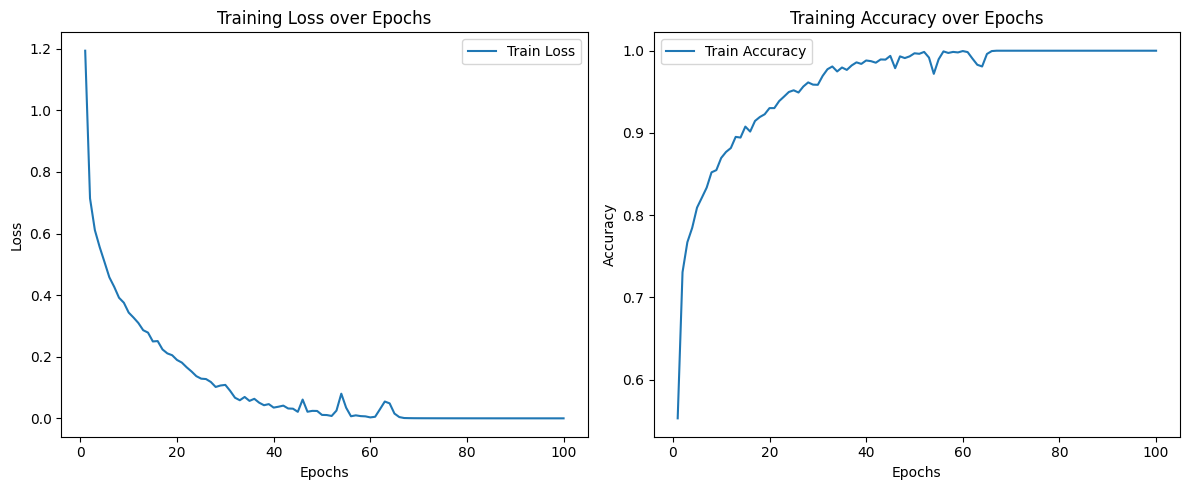

In [46]:
# # Visualize model behavior
import matplotlib.pyplot as plt

# Only plot training metrics since validation metrics weren't tracked
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()
             